# **Example PSI Model Synthesis Notebook**

Tom Schad 

----

- This notebook does an example synthesis of the global corona using a Predictive Sciences MHD model. 
- Most of the details for synthesis of any line at any time can be gleaned from this example; however, it is not currently build as its own class.  A module 'psi.py' is availabel in the examples directory to interact with the PSI models.  At some point, this may evolve into its own package. 

----

In [1]:
import pycelp 
import numpy as np
import matplotlib.pyplot as plt
##%matplotlib widget
plt.rcParams['figure.dpi'] = 150
import os
os.environ["XUVTOP"] = '/usr/local/ssw/packages/chianti/dbase/'
import psi
import sunpy.coordinates.sun as sun
import sunpy.sun.constants as constants
plt.rcParams["image.origin"]='lower'   ## have to worry about flips? 
plt.rcParams["image.interpolation"]='nearest'
from scipy.interpolate import RegularGridInterpolator as rgi
from scipy.interpolate import interp1d
import multiprocessing
import tqdm

def euler_ry(alpha):
    '''Euler rotation matrix about y axis '''
    ry = np.array([[ np.cos(alpha), 0., np.sin(alpha)],
                   [            0., 1., 0.],
                   [-np.sin(alpha), 0., np.cos(alpha)]])
    return ry

def euler_rz(alpha):
    '''Euler rotation matrix about z axis '''
    rz = np.array([[ np.cos(alpha), -np.sin(alpha), 0.],
                   [ np.sin(alpha),  np.cos(alpha), 0.],
                   [            0.,             0., 1.]])
    return rz

## **Create an instance of the psi.Model class to load and interact with PSI coronal model data**

- Models used here were downloaded using this website from [Predictive Sciences](https://www.predsci.com/hmi/data_access.php)
- We picked the date of the US total solar eclipse (21 Aug 2017) using the med-cor-thermo2 model for this demonstration. 
- I had selected 12 UTC for the download time.  I'm not sure at this time where timestep information in the PSI models made be located.

In [2]:
## https://www.predsci.com/data/runs/cr2194-medium/hmi_mast_mas_std_0201/
## carrington rotation 2194
modelName = 'hmi__med-cor-thermo2-std01__med-hel-poly-std01'
corona = psi.Model('/home/tschad/Dropbox/psiData_21Aug2017_thermo2_12UTC/corona/')

In [3]:
## return the instance name for some basic information on the class
corona

psi Model class
    ---------------------
    Data Directory Names: /home/tschad/Dropbox/psiData_21Aug2017_thermo2_12UTC/corona/
    Number of longitude samples: 181
    Number of latitude samples: 100
    Number of radial samples: 150
    Data shape: (181, 100, 150)
    
    Variables: 
    lons -- Longitudes [rad]
    lats -- Latitudes [rad]
    rs   -- Radial samples [solar radii units]
    temp -- temperature [K]
    ne -- electron density [cm^-3]
    bx,by,bz  -- Cartesian components of magnetic field [G]
    vx,vy,vz  -- Cartesian components of velocity field [km/s]
    bmag      -- total magnetic field intensity [B]
    thetaBlocal -- location inclination of magnetic field in solar frame [rad]
    

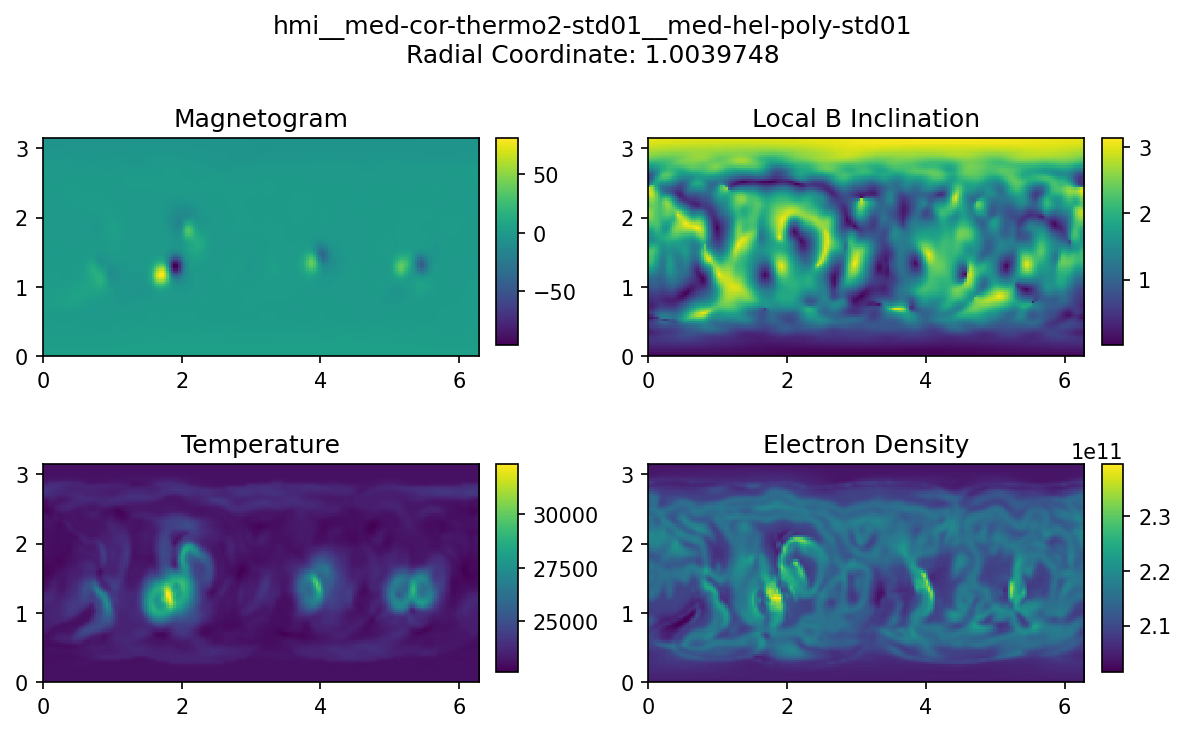

In [4]:
kk = 5

fig,ax = plt.subplots(2,2,figsize = (8,5))
ax = ax.flatten()
ax[0].imshow(corona.bmag[:,:,kk].T*np.cos(corona.thetaBlocal[:,:,kk]).T,extent = (corona.lons.min(),corona.lons.max(),corona.lats.min(),corona.lats.max()))
ax[1].imshow(corona.thetaBlocal[:,:,kk].T,extent = (corona.lons.min(),corona.lons.max(),corona.lats.min(),corona.lats.max()))
ax[2].imshow(corona.temp[:,:,kk].T,extent = (corona.lons.min(),corona.lons.max(),corona.lats.min(),corona.lats.max()))
ax[3].imshow(corona.ne[:,:,kk].T,extent = (corona.lons.min(),corona.lons.max(),corona.lats.min(),corona.lats.max()))
labels = 'Magnetogram','Local B Inclination','Temperature','Electron Density'
for n in range(4): ax[n].set_title(labels[n])

cbars = []
for axi in ax:
 cax = axi.inset_axes([1.04, 0.05, 0.05, 0.95], transform=axi.transAxes)
 cbar1 = fig.colorbar(axi.get_images()[0],ax=axi,cax=cax)
 cbars.append(cbar1)

fig.suptitle(modelName + '\nRadial Coordinate: ' + str(corona.rs[kk]))

fig.tight_layout()

This is the GONG 2194_000 synoptic map 

<img src="https://gong.nso.edu/data/magmap/QR/mqj/201708/mrmqj170830/mrmqj170830t0205c2194_000.jpg" />

## **Initialize the pyCELP model of the line or lines to be synthesized**

- Here we start with Fe XIII 1074 nm and keep the model fairly "small" at 50 levels.  The errors incurred by using reduced numbers of atomic levels is addressed in [Schad & Dima (2020)](https://rdcu.be/b5J2X) 


In [5]:
fe13 = pycelp.Ion('fe_13',nlevels = 50)

 reading:  /usr/local/ssw/packages/chianti/dbase/fe/fe_13/fe_13.elvlc
 reading:  /usr/local/ssw/packages/chianti/dbase/fe/fe_13/fe_13.wgfa
 reading:  /usr/local/ssw/packages/chianti/dbase/fe/fe_13/fe_13.scups
 reading:  /usr/local/ssw/packages/chianti/dbase/fe/fe_13/fe_13.psplups
 using default abundances: /usr/local/ssw/packages/chianti/dbase/abundance/sun_photospheric_2009_asplund.abund
 reading:  /usr/local/ssw/packages/chianti/dbase/abundance/sun_photospheric_2009_asplund.abund
 testing default file: /usr/local/ssw/packages/chianti/dbase/ioneq/chianti.ioneq
 reading:  /usr/local/ssw/packages/chianti/dbase/ioneq/chianti.ioneq
 setting up electron collision rate factors
 setting up proton  collision rate factors
 setting up non-dipole radiative rate factors
 getting non-dipole rate factors
 setting up dipole radiative rate factors


## **Calculate the statistical equilibrium for every cell**

- Here the statistical equilibrium is calculated for the Ion for each cell in the PSI model and the results of the upper level populations, alignments, and total ion population are stored in arrays. 
- The advantage of doing it this way is that that statistical equilibrium does not change with viewing angle, and so if you want to synthesis the polarized intensities at a different viewing angle, you do not have to recalculate the statistical equilibrium. 

In [6]:
def work(argin): 
    
    ii,jj,kk = argin 
    
    edens = corona.ne[ii,jj,kk]
    etemp = corona.temp[ii,jj,kk]
    ht = (corona.rs[kk]-1).clip(1.e-8)
    thetab = np.rad2deg(corona.thetaBlocal[ii,jj,kk])
    
    fe13.calc_rho_sym(edens,etemp,ht, thetab)
    
    ln1 = fe13.get_emissionLine(10747.)
    ln2 = fe13.get_emissionLine(10798.)
    
    return (ii,jj,kk,ln1.C_coeff,ln1.upper_level_alignment, 
                ln2.C_coeff,ln2.upper_level_alignment)
            
ncpus = multiprocessing.cpu_count()
arg_array = []
for ii in range(0,181,1): 
    for jj in range(0,100,1): 
        for kk in range(0,150,1): 
            arg_array.append([ii,jj,kk])
         
ccoef_10747 = np.zeros_like(corona.bx)
align_10747 = np.zeros_like(corona.bx)
ccoef_10798 = np.zeros_like(corona.bx)
align_10798 = np.zeros_like(corona.bx)

p     = multiprocessing.Pool(processes=ncpus) 
rs    = p.imap(work,arg_array)
p.close()

for res in tqdm.tqdm(rs,total = len(arg_array)): 
    ii,jj,kk,r1,a1,r2,a2 = res 
    ccoef_10747[ii,jj,kk] = r1
    align_10747[ii,jj,kk] = a1
    ccoef_10798[ii,jj,kk] = r2
    align_10798[ii,jj,kk] = a2

100%|███████████████████████████████████████████████████████████████████████| 2715000/2715000 [07:23<00:00, 6116.87it/s]


## **Setup forward synthesis geometry**

- This is set up to synthesize a FOV from an arbitrary observer's position, def

### Observer's Position

In [7]:
## not yet sure what to use here?  How to get fractional carrington rotation of the PSI data?
crn        = 2194.1  
crt        = sun.carrington_rotation_time(crn)
obsLon     = sun.L0(crt).rad
obsLat     = sun.B0(crt).rad
Obs_Sun_AU = sun.earth_distance(crt).value
rsunarc    = sun.angular_radius(crt).value  ## radius of sun in arcseconds .. later replace with sun ephemeris

print('Carrington Rotation Time:       ',crt)
print('Observers Longitude [deg]:      ',np.rad2deg(obsLon))
print('Observers Latitude [deg]:       ',np.rad2deg(obsLat))
print('Observers distance to Sun [AU]: ',Obs_Sun_AU)
print('Apparent solar radius [arcsec]: ',rsunarc)

Carrington Rotation Time:        2017-08-19 04:44:52.946
Observers Longitude [deg]:       323.9999982980418
Observers Latitude [deg]:        6.830680503300187
Observers distance to Sun [AU]:  1.012050123894962
Apparent solar radius [arcsec]:  947.8098777838427


In [8]:
rObs     = Obs_Sun_AU * (1.495978707e11/6.96340e8)     ## rObs is the radial position of the observer in solar radii
thetaObs = np.pi/2. - obsLat   ## Observers latitude in the PSI model geometry 
phiObs   = obsLon ## Observers Lon in PSI model geometry
## cartesian position of Observer in PSI model geometery (units of solar radii)
xObs,yObs,zObs = rObs*np.sin(thetaObs)*np.cos(phiObs),rObs*np.sin(thetaObs)*np.sin(phiObs),rObs*np.cos(thetaObs)
print(xObs,yObs,zObs)

174.65060561060434 -126.89110044448852 25.859384238598253


### Synthesized Field-of-View Size and Sampling

- The synthesis geometry will have the x axis pointed toward the observer.  Z is aligned with polar axis. 

In [9]:
yfov_range = (-3.*rsunarc,+3*rsunarc)
zfov_range = (-3.*rsunarc,+3*rsunarc)
arcsamp    = 20.  ## sampling in arcsecond
nysamp = int(np.ceil((yfov_range[1]-yfov_range[0])/arcsamp))
nzsamp = int(np.ceil((zfov_range[1]-zfov_range[0])/arcsamp))
yarc = np.linspace(yfov_range[0],yfov_range[1],nysamp)
zarc = np.linspace(zfov_range[0],zfov_range[1],nzsamp)
yya,zza  = np.meshgrid(yarc,zarc,indexing = 'ij')
rra = np.sqrt(yya**2. + zza**2.) 
mask_ondisk = 1.*(rra>rsunarc)    ## a mask where the field of view cross the solar disk

### Calculate ray samples along each line-of-sight

In [10]:
## First find the cartestian points of each line of sight in the zy plane of the observer's geometry 
xxObs = np.zeros_like(yya)
yyObs = rObs * np.tan(np.deg2rad(yya/3600.))
zzObs = rObs * np.tan(np.deg2rad(zza/3600.))

## rotate these points into the model geometry with Euler rotation
rotm = euler_rz(-phiObs) @ euler_ry(-(thetaObs-np.pi/2.))
xyz_model = rotm  @ np.stack((xxObs.flatten(),yyObs.flatten(),zzObs.flatten()))  ## earlier I had the rotation matrix as the transpose...not sure why..incorrect?

## NOW WITH THE XYZ_MODEL POINTS AND THE LOCATION OF THE OBSERVER,
## come up with the parametric equations for the los of sight
losvec    = np.stack((xObs-xyz_model[0,:],yObs-xyz_model[1,:],zObs - xyz_model[2,:]))
losveclen = np.linalg.norm(losvec,axis=0,ord=2,keepdims = True)
losvec    = losvec / losveclen
startpt   = xyz_model

In [11]:
## get minimum angular spacing
lons,lats,rs = corona.lons,corona.lats,corona.rs
m1 = np.min(np.abs(lons - np.roll(lons,1)))
m2 = np.min(np.abs(lats - np.roll(lats,1)))
dth = np.min([m1,m2])/2.  ## min angular spacing divided by 2 

In [12]:
nrays   = startpt.shape[1]
ray_npt = int(np.ceil(np.pi/dth))
print('Number of rays to trace: ',nrays) 
print('Max number of samples per ray: ',ray_npt)

tan_tharr = np.tan(np.linspace(-0.98*np.pi/2,0.98*np.pi/2,ray_npt))
rpt = np.linalg.norm(startpt,axis=0,ord=2)  ## radius of starting point in zy observer's plane 

Number of rays to trace:  81225
Max number of samples per ray:  286


In [13]:
## Magic! --- gets the cartesin coordinates in the PSI model coordinate frame for all ray samples 
## may still need to slice off the dlen portion for the trapz integration?
rays_xyz =  startpt[None,:,:] + (losvec * (tan_tharr[:,None] * rpt[None,:])[:,None,:])
rays_xyz = np.swapaxes(rays_xyz,1,2)

In [14]:
print(rays_xyz.shape)

(286, 81225, 3)


In [15]:
## get spherical coordinates of rays
rays_sph = np.zeros_like(rays_xyz)
rays_sph[:,:,0] = np.linalg.norm(rays_xyz,axis=2)
rays_sph[:,:,1] = np.arccos(rays_xyz[:,:,2] / rays_sph[:,:,0]) 
rays_sph[:,:,2] = np.arctan2(rays_xyz[:,:,1] , rays_xyz[:,:,0]) 
rays_sph[:,:,2][rays_sph[:,:,2] <0] += 2.*np.pi ## so that it falls in the simulation domain 

/tmp/ipykernel_218951/642216034.py:4: RuntimeWarning: invalid value encountered in true_divide
  rays_sph[:,:,1] = np.arccos(rays_xyz[:,:,2] / rays_sph[:,:,0])


In [16]:
print(rays_sph.shape)

(286, 81225, 3)


In [17]:
rays_xyz = rays_xyz.reshape(ray_npt*nrays,3)
rays_sph = rays_sph.reshape(ray_npt*nrays,3)

## **Interpolate model variables at ray samples**

In [18]:
#### Get interpolating functions for all necessary simulation data
ccoefInt  = rgi((lons,lats,rs),ccoef_10747,method = 'linear',fill_value = 0.,bounds_error = False)
alignInt  = rgi((lons,lats,rs),align_10747,method = 'linear',fill_value = 0.,bounds_error = False)
bxInt   = rgi((lons,lats,rs),corona.bx,method = 'linear',fill_value = 0.,bounds_error = False)
byInt   = rgi((lons,lats,rs),corona.by,method = 'linear',fill_value = 0.,bounds_error = False)
bzInt   = rgi((lons,lats,rs),corona.bz,method = 'linear',fill_value = 0.,bounds_error = False)
## add velocities! 

In [19]:
## get bx,by,bz in PSI geometry for all the ray points
%time bx_rays = bxInt(rays_sph[:,::-1])
%time by_rays = byInt(rays_sph[:,::-1]) 
%time bz_rays = bzInt(rays_sph[:,::-1]) 
%time ccoef_rays = ccoefInt(rays_sph[:,::-1]) 
%time align_rays = alignInt(rays_sph[:,::-1]) 

CPU times: user 5.7 s, sys: 1.76 s, total: 7.46 s
Wall time: 7.46 s
CPU times: user 5.82 s, sys: 1.85 s, total: 7.67 s
Wall time: 7.67 s
CPU times: user 5.71 s, sys: 1.91 s, total: 7.62 s
Wall time: 7.62 s
CPU times: user 5.99 s, sys: 1.72 s, total: 7.71 s
Wall time: 7.7 s
CPU times: user 5.62 s, sys: 1.73 s, total: 7.35 s
Wall time: 7.35 s


In [20]:
ccoef_rays = ccoef_rays.reshape(ray_npt,nrays)
align_rays = align_rays.reshape(ray_npt,nrays)

In [21]:
rays_xyz = rays_xyz.reshape(ray_npt,nrays,3)
rays_sph = rays_sph.reshape(ray_npt,nrays,3)

In [22]:
## calculate the magnetic field inclination angle wrt the line-of-sight 
bxyzs = np.stack((bx_rays,by_rays,bz_rays)).T
blens = np.linalg.norm(bxyzs,axis =1)
bxyzs = bxyzs.reshape(ray_npt,nrays,3)
blens = blens.reshape(ray_npt,nrays)
thetaBlos = np.arccos( (np.sum(bxyzs*losvec.T[None,:,:],axis=2)/blens).clip(min = -1,max=1))
thetaBlos[np.isnan(thetaBlos)] = 0.

/tmp/ipykernel_218951/3178097367.py:6: RuntimeWarning: invalid value encountered in true_divide
  thetaBlos = np.arccos( (np.sum(bxyzs*losvec.T[None,:,:],axis=2)/blens).clip(min = -1,max=1))


In [23]:
## angle between losvec and the vector from disk center
thetaDClos = np.arccos( (np.sum(rays_xyz*losvec.T[None,:,:],axis=2)/rays_sph[:,:,0]).clip(min = -1,max=1))

/tmp/ipykernel_218951/3344776035.py:2: RuntimeWarning: invalid value encountered in true_divide
  thetaDClos = np.arccos( (np.sum(rays_xyz*losvec.T[None,:,:],axis=2)/rays_sph[:,:,0]).clip(min = -1,max=1))


In [24]:
## get projection of B onto plane perpendicular to LOS
## and the projection of DC vector onto same plane
Bperp  = bxyzs - (blens*np.cos(thetaBlos))[:,:,None] * losvec.T[None,:,:]
DCperp = rays_xyz - (rays_sph[:,:,0]*np.cos(thetaDClos))[:,:,None] * losvec.T[None,:,:]

In [25]:
del thetaDClos

In [26]:
## find angle between Bperp and DCperp, which is the azimuthal angle relative to disk center
costhetaAzi = np.sum((Bperp*DCperp),axis=2)/(np.linalg.norm(Bperp,axis = 2)*np.linalg.norm(DCperp,axis = 2))
del Bperp
del DCperp
thetaAzi = np.arccos(costhetaAzi.clip(min =-1,max=1))
thetaAzi[np.isnan(thetaAzi)] = 0.
del costhetaAzi

/tmp/ipykernel_218951/3888707345.py:2: RuntimeWarning: invalid value encountered in true_divide
  costhetaAzi = np.sum((Bperp*DCperp),axis=2)/(np.linalg.norm(Bperp,axis = 2)*np.linalg.norm(DCperp,axis = 2))


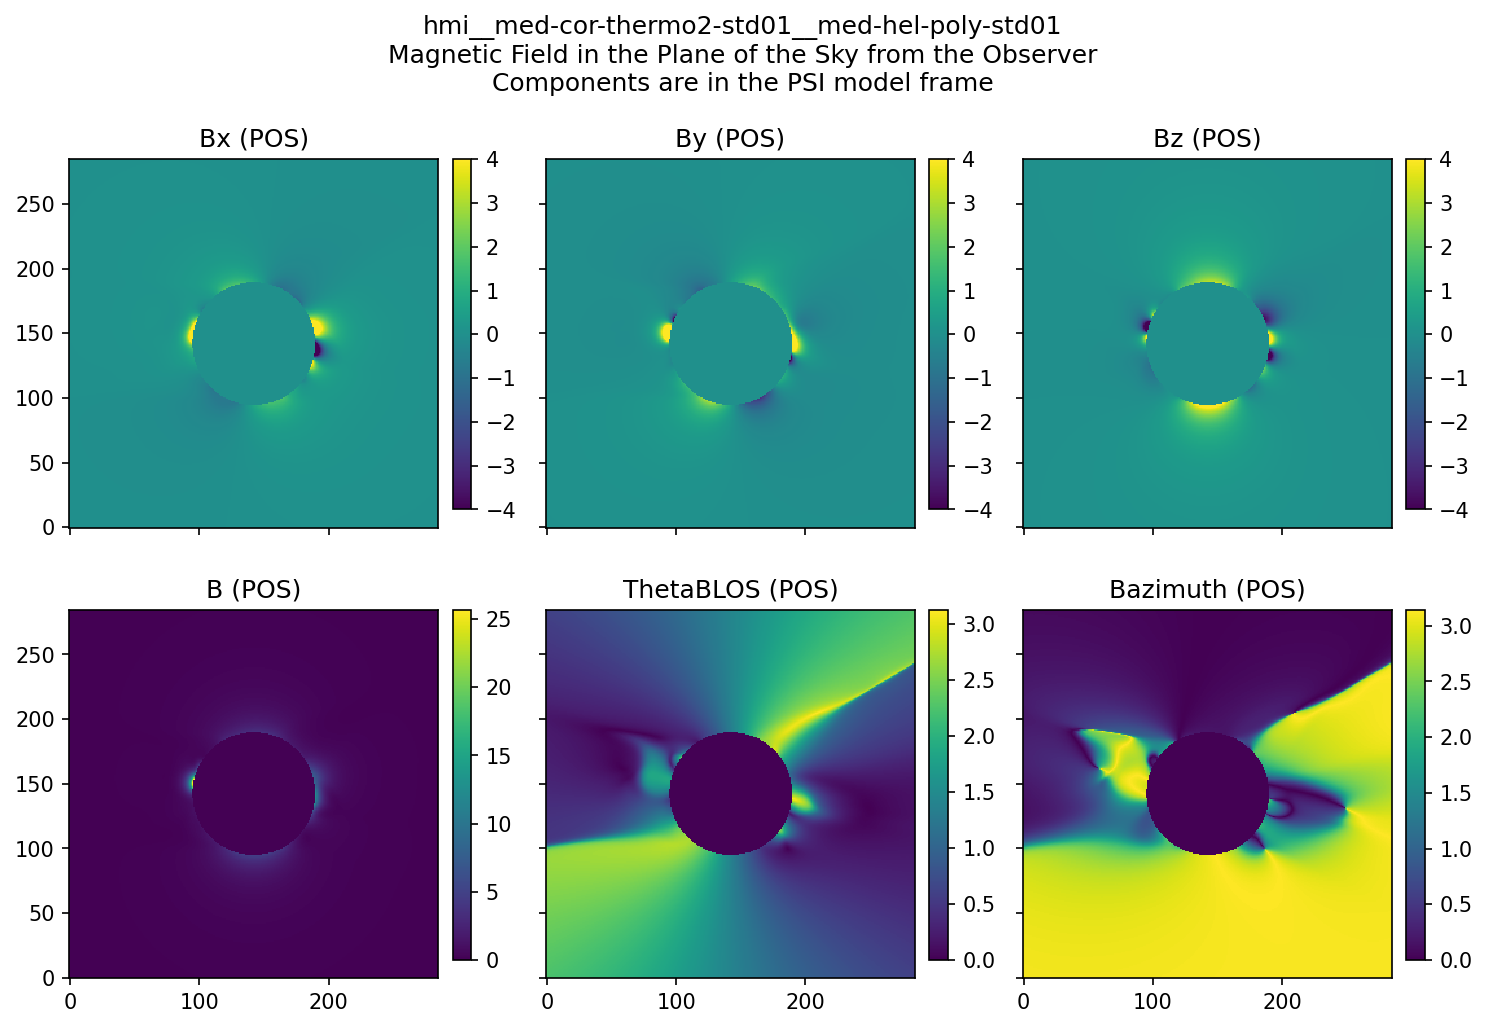

In [27]:
fig,ax = plt.subplots(2,3,figsize = (10,7),sharex=True,sharey=True)
ax = ax.flatten()
im0 = ax[0].imshow(bx_rays.reshape(ray_npt,nrays)[ray_npt//2,:].reshape(*yya.shape).T)
im1 = ax[1].imshow(by_rays.reshape(ray_npt,nrays)[ray_npt//2,:].reshape(*yya.shape).T)
im2 = ax[2].imshow(bz_rays.reshape(ray_npt,nrays)[ray_npt//2,:].reshape(*yya.shape).T)

im3 = ax[3].imshow(blens[ray_npt//2,:].reshape(*yya.shape).T)
im4 = ax[4].imshow(thetaBlos[ray_npt//2,:].reshape(*yya.shape).T)
im5 = ax[5].imshow(thetaAzi[ray_npt//2,:].reshape(*yya.shape).T)
for im in im0,im1,im2,: im.set_clim(-4,4)

labs = 'Bx (POS)','By (POS)','Bz (POS)','B (POS)','ThetaBLOS (POS)','Bazimuth (POS)'
for n in range(6): ax[n].set_title(labs[n])

cbars = []
for axi in ax:
 cax = axi.inset_axes([1.04, 0.05, 0.05, 0.95], transform=axi.transAxes)
 cbar1 = fig.colorbar(axi.get_images()[0],ax=axi,cax=cax)
 cbars.append(cbar1)

fig.suptitle(modelName + '\nMagnetic Field in the Plane of the Sky from the Observer\nComponents are in the PSI model frame') 

fig.tight_layout()

## **Forward Synthesize Emission Line** 

In [28]:
ln1 = fe13.get_emissionLine(10747.)
geff,D_coeff,E_coeff = ln1.geff,ln1.Dcoeff,ln1.Ecoeff

In [29]:
ccoef_rays.shape,align_rays.shape,thetaBlos.shape,blens.shape,thetaAzi.shape,rays_xyz.shape

((286, 81225),
 (286, 81225),
 (286, 81225),
 (286, 81225),
 (286, 81225),
 (286, 81225, 3))

In [30]:
epsI   = ccoef_rays*(1.0+(1./(2.*np.sqrt(2.)))*(3.*np.cos(thetaBlos)**2 - 1.)*D_coeff*align_rays)
epsQnr = ccoef_rays*(3./(2.*np.sqrt(2.)))*(np.sin(thetaBlos)**2)*D_coeff*align_rays
epsQ   = np.cos(2.*thetaAzi)*epsQnr
epsU   = -np.sin(2.*thetaAzi)*epsQnr
epsV   = ccoef_rays*np.cos(thetaBlos)*(1399612.2*blens)*(geff + E_coeff*align_rays)

In [31]:
## get the sample points measured in distance from the furtherest point
dray = (tan_tharr[:,None] * rpt[None,:])
dray = dray - np.nanmin(dray,axis=0)[None,:]
dray = dray * constants.radius.value*100.

In [37]:
epsI_int = np.trapz(epsI,axis=0).reshape(*yya.shape).T
epsQ_int = np.trapz(epsQ,axis=0).reshape(*yya.shape).T
epsU_int = np.trapz(epsU,axis=0).reshape(*yya.shape).T
epsV_int = np.trapz(epsV,axis=0).reshape(*yya.shape).T  ## ??? how to phrase this? 

In [38]:
epsI.shape,dray.shape

((286, 81225), (286, 81225))

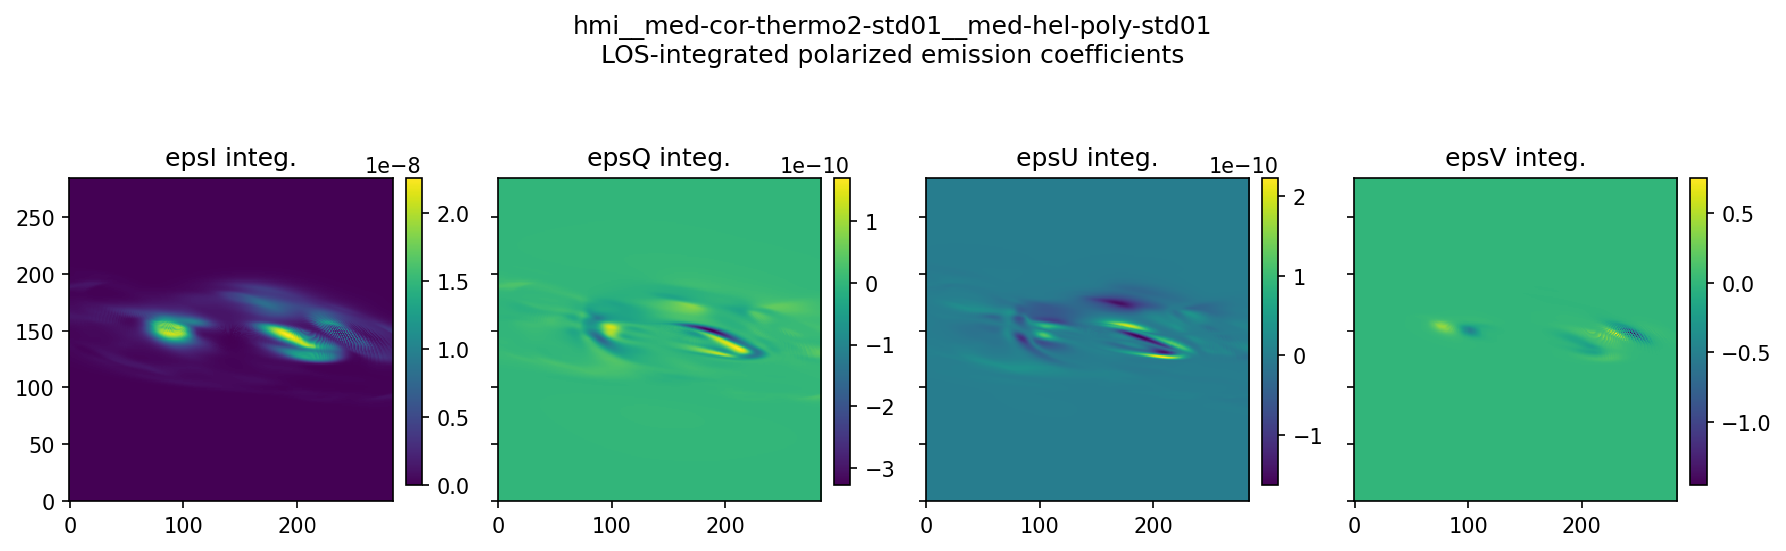

In [39]:
fig,ax = plt.subplots(1,4,figsize = (12,4),sharex=True,sharey=True)
ax = ax.flatten()
im0 = ax[0].imshow(epsI_int)
im1 = ax[1].imshow(epsQ_int)
im2 = ax[2].imshow(epsU_int)
im3 = ax[3].imshow(epsV_int)
labs = 'epsI integ.','epsQ integ.','epsU integ.','epsV integ.'
for n in range(4): ax[n].set_title(labs[n])

cbars = []
for axi in ax:
 cax = axi.inset_axes([1.04, 0.05, 0.05, 0.95], transform=axi.transAxes)
 cbar1 = fig.colorbar(axi.get_images()[0],ax=axi,cax=cax)
 cbars.append(cbar1)

fig.suptitle(modelName + '\nLOS-integrated polarized emission coefficients') 

fig.tight_layout()

## Generate polarized spectra

- The coefficients along each ray are stored above in the epsI,epsQ,epsU,epsV variables. 
- In order to generate spectra, we need to multiple these by the appropriate normalized profile function (Gaussian) and/or the correctly scaled derivative profile 
- Then do the LOS integrated along the ray and as a function of wavelength. 

WORK TO BE DONE

In [49]:
ccoef_10747.shape
%matplotlib widget

In [51]:
corona

psi Model class
    ---------------------
    Data Directory Names: /home/tschad/Dropbox/psiData_21Aug2017_thermo2_12UTC/corona/
    Number of longitude samples: 181
    Number of latitude samples: 100
    Number of radial samples: 150
    Data shape: (181, 100, 150)
    
    Variables: 
    lons -- Longitudes [rad]
    lats -- Latitudes [rad]
    rs   -- Radial samples [solar radii units]
    temp -- temperature [K]
    ne -- electron density [cm^-3]
    bx,by,bz  -- Cartesian components of magnetic field [G]
    vx,vy,vz  -- Cartesian components of velocity field [km/s]
    bmag      -- total magnetic field intensity [B]
    thetaBlocal -- location inclination of magnetic field in solar frame [rad]
    

In [54]:
plt.figure()
plt.imshow(ccoef_10747[:,:,48])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …